**Key Components:**
1. **EDA & Visualization**: Understand relationships between features and revenue
2. **Genre Analysis**: Extract genre-based predictive signals
3. **Cast & Director Features**: Engineer success metrics from cast/crew data
4. **Temporal Features**: Capture seasonality and release timing effects
5. **Aggregation Features**: Studio and genre-level statistics
6. **Encoding Strategies**: Transform categorical variables for modeling


# Section 1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
from pathlib import Path
import json
import ast
from datetime import datetime
from collections import Counter

from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from scipy.stats import zscore, skew, kurtosis

# Set visualization styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configuration - Updated paths for new structure
PROJECT_ROOT = Path("/home/asif/AI-Movie-Hit-Predictor")
DATA_DIR = PROJECT_ROOT / "project_components" / "data"
CONSOLIDATED_DATA = DATA_DIR / "03_consolidated_movies.csv"

print("✓ All libraries imported successfully!")
print(f"✓ Project root: {PROJECT_ROOT}")
print(f"✓ Data directory: {DATA_DIR}")
print(f"✓ Consolidated data path: {CONSOLIDATED_DATA}")

✓ All libraries imported successfully!
✓ Project root: /home/asif/AI-Movie-Hit-Predictor
✓ Data directory: /home/asif/AI-Movie-Hit-Predictor/project_components/data
✓ Consolidated data path: /home/asif/AI-Movie-Hit-Predictor/project_components/data/03_consolidated_movies.csv


---

## Section 2: Load and Prepare Data

In [3]:
df = pd.read_csv(CONSOLIDATED_DATA)

print(f"\n✓ Dataset loaded: {df.shape[0]} movies × {df.shape[1]} features")
print(f"\nColumn Information:")
print(f"  Data types:\n{df.dtypes}")

# Basic data preparation
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

print(f"\n✓ Date conversion completed")
print(f"\nBasic Statistics:")
print(f"  Total movies: {len(df)}")
print(f"  Movies with revenue: {df['revenue'].notna().sum()}")
print(f"  Movies with budget: {df['budget'].notna().sum()}")
print(f"  Date range: {df['release_date'].min()} to {df['release_date'].max()}")

# Display sample data
print(f"\nSample Data (first 3 rows):")
print(df[['id', 'title', 'budget', 'revenue', 'popularity', 'runtime', 'release_date']].head(3))


✓ Dataset loaded: 11506 movies × 20 features

Column Information:
  Data types:
budget                  float64
genres                      str
homepage                    str
id                        int64
keywords                    str
original_language           str
original_title              str
overview                    str
popularity              float64
production_companies        str
production_countries        str
release_date                str
revenue                 float64
runtime                 float64
spoken_languages            str
status                      str
tagline                     str
title                       str
vote_average            float64
vote_count                int64
dtype: object

✓ Date conversion completed

Basic Statistics:
  Total movies: 11506
  Movies with revenue: 4803
  Movies with budget: 4803
  Date range: 1895-06-10 00:00:00 to 2022-11-25 00:00:00

Sample Data (first 3 rows):
       id                                     title   

---

## Section 3: Exploratory Data Analysis with Visualizations

### 3.1 Correlation Matrix and Heatmap

In [4]:
# Select numeric columns with sufficient data
numeric_cols = ['budget', 'revenue', 'runtime', 'popularity', 'vote_average', 'vote_count']
df_corr = df[numeric_cols].dropna()

print(f"\n✓ Correlation dataset: {len(df_corr)} movies with complete numeric data")

# Calculate correlation matrix
corr_matrix = df_corr.corr()

print(f"\nCorrelation with Revenue:")
print(corr_matrix['revenue'].sort_values(ascending=False))

# Visualize correlation matrix
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='RdBu',
    zmid=0,
    text=np.round(corr_matrix.values, 2),
    texttemplate='%{text}',
    textfont={"size": 10},
    colorbar=dict(title="Correlation")
))

fig.update_layout(
    title='Correlation Matrix: Movie Features vs Revenue',
    width=900,
    height=800,
    xaxis_title='Features',
    yaxis_title='Features'
)
fig.show()

print("\n✓ Correlation heatmap generated")


✓ Correlation dataset: 4801 movies with complete numeric data

Correlation with Revenue:
revenue         1.000000
vote_count      0.781462
budget          0.730798
popularity      0.644677
runtime         0.251093
vote_average    0.197286
Name: revenue, dtype: float64



✓ Correlation heatmap generated


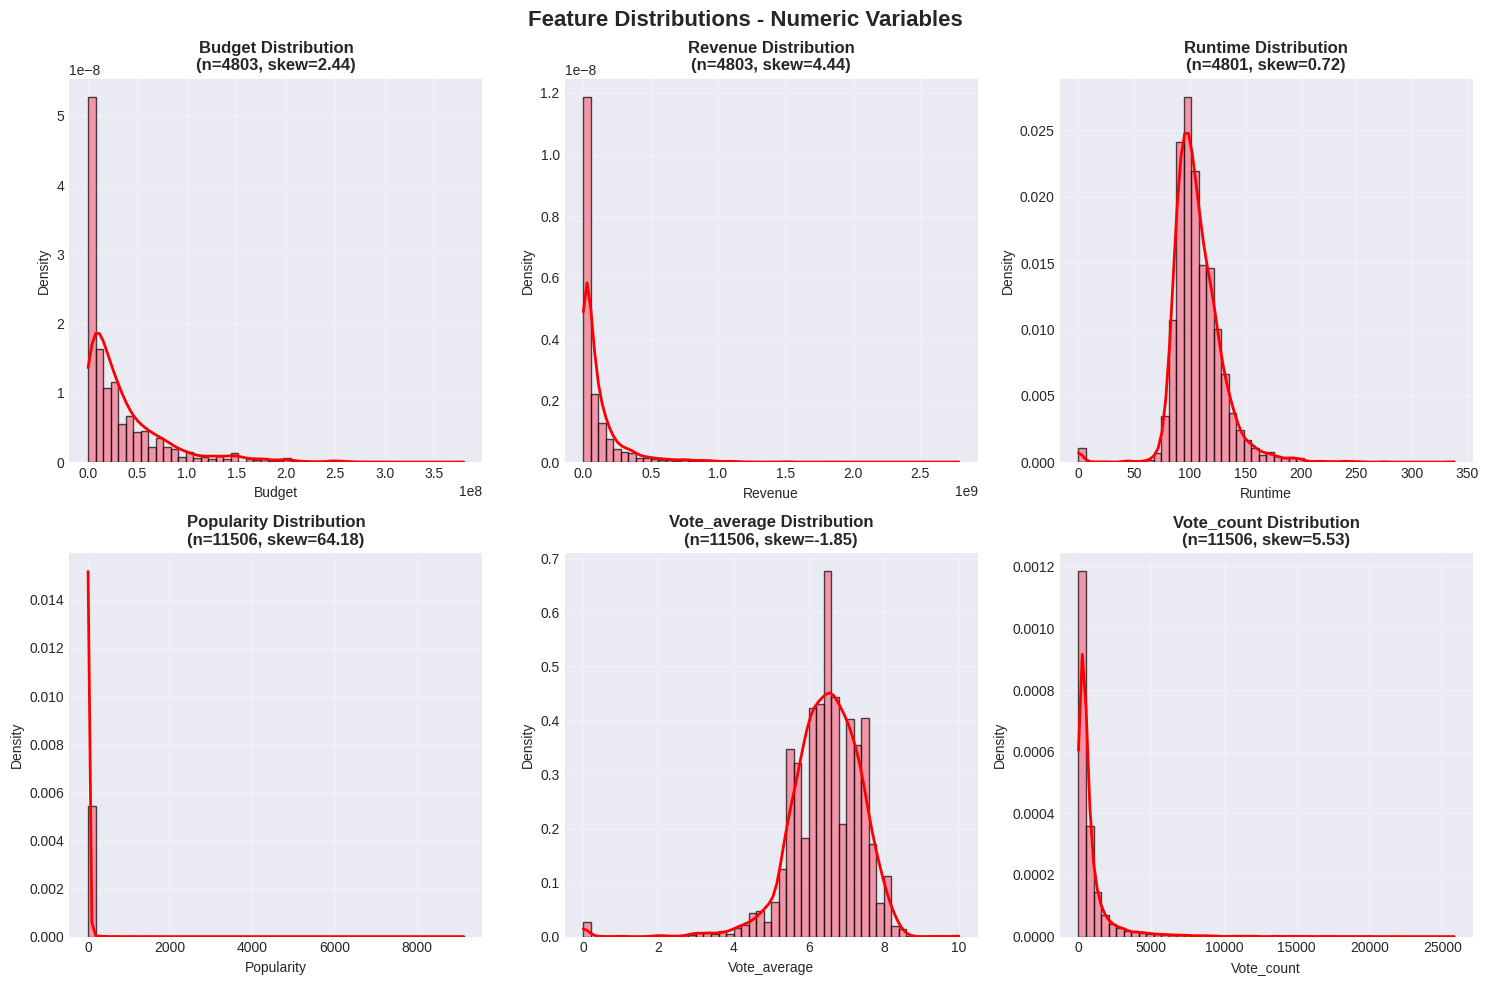

✓ Feature distribution plots generated


In [5]:
### 3.2 Feature Distributions

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Feature Distributions - Numeric Variables', fontsize=16, fontweight='bold')

features_to_plot = ['budget', 'revenue', 'runtime', 'popularity', 'vote_average', 'vote_count']

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx // 3, idx % 3]
    data = df[feature].dropna()
    
    # Plot histogram with KDE
    ax.hist(data, bins=50, alpha=0.7, edgecolor='black', density=True)
    ax.set_title(f'{feature.capitalize()} Distribution\n(n={len(data)}, skew={skew(data):.2f})', 
                 fontweight='bold')
    ax.set_xlabel(feature.capitalize())
    ax.set_ylabel('Density')
    
    # Add KDE line
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(data[data > 0] if feature in ['budget', 'revenue', 'vote_count'] else data)
    x_range = np.linspace(data.min(), data.max(), 100)
    ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Feature distribution plots generated")

In [6]:
### 3.3 Budget vs Revenue Analysis

# Create scatter plot
df_financial = df[['budget', 'revenue', 'title']].dropna()

fig = px.scatter(
    df_financial,
    x='budget',
    y='revenue',
    hover_data=['title'],
    title='Budget vs Revenue Analysis',
    labels={'budget': 'Budget ($)', 'revenue': 'Revenue ($)'},
    opacity=0.6
)

# Add break-even line
max_val = max(df_financial['budget'].max(), df_financial['revenue'].max())
fig.add_trace(go.Scatter(
    x=[0, max_val],
    y=[0, max_val],
    mode='lines',
    name='Break Even',
    line=dict(dash='dash', color='red')
))

# Add profitability zones
fig.add_trace(go.Scatter(
    x=[0, max_val],
    y=[0, max_val * 1.5],
    mode='lines',
    name='1.5x ROI Threshold',
    line=dict(dash='dot', color='orange')
))

fig.update_xaxes(type='log', title='Budget ($, log scale)')
fig.update_yaxes(type='log', title='Revenue ($, log scale)')
fig.show()

print(f"\n✓ Budget vs Revenue scatter plot generated")
print(f"  Movies with profitability data: {len(df_financial)}")
print(f"  Average ROI: {((df_financial['revenue'] / df_financial['budget']).mean() - 1) * 100:.1f}%")


✓ Budget vs Revenue scatter plot generated
  Movies with profitability data: 4803
  Average ROI: inf%


In [7]:
### 3.4 Runtime vs Revenue

fig = px.scatter(
    df[['runtime', 'revenue', 'popularity', 'title']].dropna(),
    x='runtime',
    y='revenue',
    size='popularity',
    hover_data=['title'],
    title='Runtime vs Revenue (sized by popularity)',
    labels={'runtime': 'Runtime (minutes)', 'revenue': 'Revenue ($)'},
    opacity=0.6
)

fig.update_yaxes(type='log', title='Revenue ($, log scale)')
fig.show()

print("✓ Runtime vs Revenue scatter plot generated")

✓ Runtime vs Revenue scatter plot generated


OUTLIER DETECTION ANALYSIS


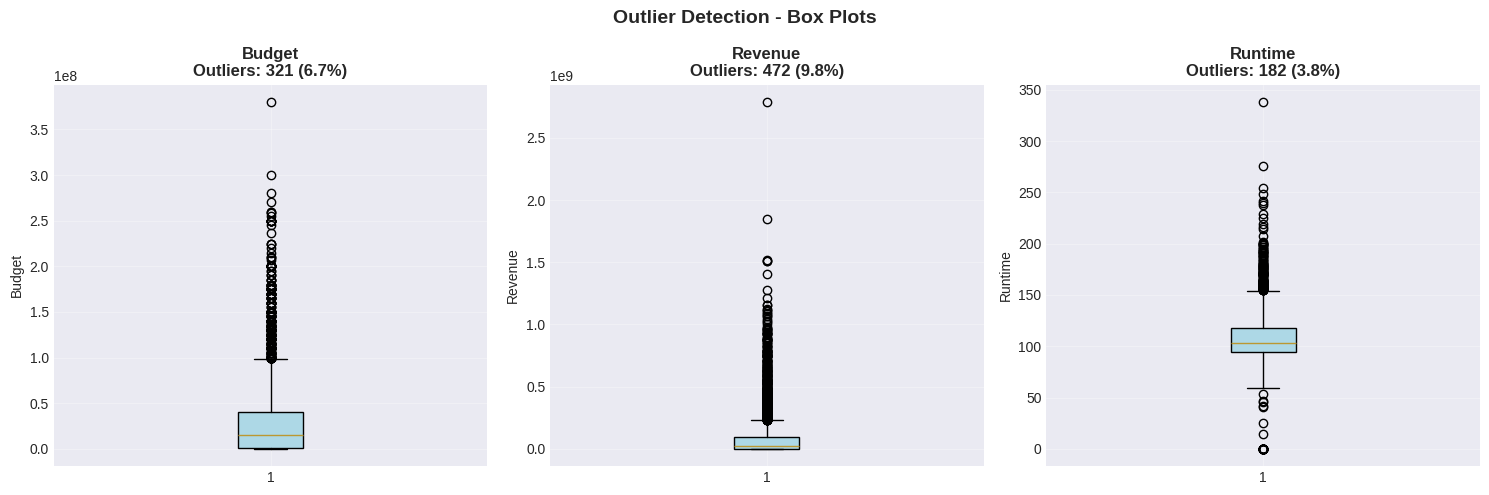


--- Outlier Statistics by IQR Method ---

BUDGET:
  Q1: 790,000, Q3: 40,000,000, IQR: 39,210,000
  Bounds: [-58,025,000, 98,815,000]
  Outliers: 321 (6.7%)

REVENUE:
  Q1: 0, Q3: 92,917,187, IQR: 92,917,187
  Bounds: [-139,375,780, 232,292,968]
  Outliers: 472 (9.8%)

RUNTIME:
  Q1: 94, Q3: 118, IQR: 24
  Bounds: [58, 154]
  Outliers: 182 (3.8%)

POPULARITY:
  Q1: 8, Q3: 22, IQR: 13
  Bounds: [-12, 42]
  Outliers: 1156 (10.0%)


In [8]:
### 3.5 Outlier Detection

print("=" * 80)
print("OUTLIER DETECTION ANALYSIS")
print("=" * 80)

# Box plot for outlier visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Outlier Detection - Box Plots', fontsize=14, fontweight='bold')

for idx, feature in enumerate(['budget', 'revenue', 'runtime']):
    ax = axes[idx]
    data = df[feature].dropna()
    
    bp = ax.boxplot(data, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    
    # Calculate outliers using IQR method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)]
    
    ax.set_title(f'{feature.capitalize()}\nOutliers: {len(outliers)} ({len(outliers)/len(data)*100:.1f}%)', 
                 fontweight='bold')
    ax.set_ylabel(feature.capitalize())
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed outlier statistics
print("\n--- Outlier Statistics by IQR Method ---")
for feature in ['budget', 'revenue', 'runtime', 'popularity']:
    data = df[feature].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    print(f"\n{feature.upper()}:")
    print(f"  Q1: {Q1:,.0f}, Q3: {Q3:,.0f}, IQR: {IQR:,.0f}")
    print(f"  Bounds: [{lower_bound:,.0f}, {upper_bound:,.0f}]")
    print(f"  Outliers: {len(outliers)} ({len(outliers)/len(data)*100:.1f}%)")

---

## Section 4: Genre Popularity Scores

### 4.1 Genre Feature Extraction and Analysis

In [9]:
def extract_genres(genres_json):
    """Extract genre names from JSON string"""
    try:
        if pd.isna(genres_json):
            return []
        genres_list = ast.literal_eval(genres_json) if isinstance(genres_json, str) else genres_json
        if isinstance(genres_list, list):
            return [g['name'] for g in genres_list if isinstance(g, dict) and 'name' in g]
        return []
    except:
        return []

# Apply genre extraction
df['genres_list'] = df['genres'].apply(extract_genres)
df['primary_genre'] = df['genres_list'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')
df['genre_count'] = df['genres_list'].apply(len)

print(f"\n Genres extracted")
print(f"  Movies with genre data: {(df['genres_list'].apply(len) > 0).sum()}")
print(f"  Unique genres: {len(set([g for genres in df['genres_list'] for g in genres]))}")

# Calculate genre popularity scores
genre_stats = df[df['revenue'].notna()].explode('genres_list').groupby('genres_list').agg({
    'revenue': ['mean', 'median', 'count'],
    'budget': 'mean',
    'popularity': 'mean',
    'vote_average': 'mean'
}).round(0)

genre_stats.columns = ['avg_revenue', 'median_revenue', 'movie_count', 'avg_budget', 'avg_popularity', 'avg_rating']
genre_stats = genre_stats.sort_values('avg_revenue', ascending=False)

print(f"\nTop Genres by Average Revenue:")
print(genre_stats.head(10))

# Visualize genre performance
fig = px.bar(
    genre_stats.reset_index().head(15),
    x='genres_list',
    y='avg_revenue',
    color='avg_revenue',
    title='Top 15 Genres by Average Revenue',
    labels={'genres_list': 'Genre', 'avg_revenue': 'Average Revenue ($)'},
    color_continuous_scale='viridis'
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

# Create genre popularity score mapping
genre_popularity_scores = genre_stats['avg_revenue'].to_dict()

print(f"\n Genre popularity scores calculated")


 Genres extracted
  Movies with genre data: 4775
  Unique genres: 20

Top Genres by Average Revenue:
                 avg_revenue  median_revenue  movie_count  avg_budget  \
genres_list                                                             
Animation        225693025.0     120450950.0          234  66465902.0   
Adventure        208660204.0      95939404.0          790  66326861.0   
Fantasy          193354245.0      89477332.0          424  63560605.0   
Family           162345495.0      64459316.0          513  50719512.0   
Science Fiction  152456515.0      50244700.0          535  51865551.0   
Action           141213098.0      54550710.0         1154  51510751.0   
War               84155874.0      28188328.0          144  35282457.0   
Thriller          81044291.0      28965700.0         1274  31968207.0   
Mystery           78300927.0      28560550.0          348  30744487.0   
Comedy            71289499.0      17428582.0         1722  25313421.0   

                 avg_


 Genre popularity scores calculated


In [10]:
### 4.2 Genre-Level Features

# Create genre features
df['primary_genre_revenue'] = df['primary_genre'].map(genre_popularity_scores).fillna(
    df[df['revenue'].notna()]['revenue'].mean()
)

# Genre diversity score
df['genre_diversity'] = df['genre_count'].apply(lambda x: 1 if x == 1 else 0.8 if x == 2 else 0.6 if x < 5 else 0.4)

# Multi-genre indicator
df['is_multi_genre'] = (df['genre_count'] > 1).astype(int)

print("Genre features engineered:")
print("  - primary_genre_revenue: Average revenue of primary genre")
print("  - genre_diversity: Score based on number of genres")
print("  - is_multi_genre: Binary indicator for multiple genres")

Genre features engineered:
  - primary_genre_revenue: Average revenue of primary genre
  - genre_diversity: Score based on number of genres
  - is_multi_genre: Binary indicator for multiple genres


---

## Section 5: Cast and Director Success Scores

### 5.1 Cast and Crew Feature Extraction

In [11]:

# Extract cast information
def extract_cast_names(cast_json):
    
    try:
        if pd.isna(cast_json):
            return []
        cast_list = ast.literal_eval(cast_json) if isinstance(cast_json, str) else cast_json
        if isinstance(cast_list, list):
            return [c.get('name', '') for c in cast_list[:5] if isinstance(c, dict) and 'name' in c]  # Top 5
        return []
    except:
        return []

# Extract crew information (directors)
def extract_directors(crew_json):
    """Extract director names from crew JSON"""
    try:
        if pd.isna(crew_json):
            return []
        crew_list = ast.literal_eval(crew_json) if isinstance(crew_json, str) else crew_json
        if isinstance(crew_list, list):
            return [c['name'] for c in crew_list if isinstance(c, dict) and c.get('job') == 'Director']
        return []
    except:
        return []

# Note: These fields may not exist in all datasets, so we'll create approximations
print("\nNote: Cast and crew data structure varies by dataset.")
print("Creating proxy metrics based on available data...")

# If cast column exists, extract it
if 'cast' in df.columns:
    df['cast_list'] = df['cast'].apply(extract_cast_names)
    df['cast_count'] = df['cast_list'].apply(len)
    print("Cast information extracted")
else:
    df['cast_list'] = [[]] * len(df)
    df['cast_count'] = 0
    print("⚠ Cast column not available in dataset")

# If crew column exists, extract directors
if 'crew' in df.columns:
    df['director_list'] = df['crew'].apply(extract_directors)
    df['director_count'] = df['director_list'].apply(len)
    print("Director information extracted")
else:
    df['director_list'] = [[]] * len(df)
    df['director_count'] = 0
    print("⚠ Crew column not available in dataset")

# Create proxy success metrics based on available features
print("\n--- Creating Cast/Director Proxy Metrics ---")

# Cast size correlation with revenue
if df['cast_count'].sum() > 0:
    cast_revenue = df.groupby('cast_count')['revenue'].mean()
    print(f"\nAverage Revenue by Cast Size (sample):")
    print(cast_revenue[cast_revenue.index <= 5])
else:
    # Create a proxy: movies with more popularity tend to have more famous casts
    df['cast_prominence_proxy'] = df['popularity'].fillna(df['popularity'].mean()) / df['popularity'].max()
    print("Created cast prominence proxy based on popularity")

# Director success proxy (using vote average as proxy for quality)
if df['director_count'].sum() > 0:
    director_stats = df.groupby('director_count')['vote_average'].mean()
    print(f"\nAverage Rating by Director Involvement:")
    print(director_stats[director_stats.index <= 3])
else:
    # Create a proxy: vote average as quality indicator
    df['director_quality_proxy'] = df['vote_average'].fillna(df['vote_average'].mean()) / 10
    print("Created director quality proxy based on vote average")

print("\nCast and Director features engineered")


Note: Cast and crew data structure varies by dataset.
Creating proxy metrics based on available data...
⚠ Cast column not available in dataset
⚠ Crew column not available in dataset

--- Creating Cast/Director Proxy Metrics ---
Created cast prominence proxy based on popularity
Created director quality proxy based on vote average

Cast and Director features engineered


In [12]:

# Create ensemble cast indicator
df['has_ensemble_cast'] = (df['cast_count'] >= 3).astype(int) if df['cast_count'].sum() > 0 else 0

# Cast marketability proxy (combination of popularity + vote average)
df['cast_marketability'] = (
    (df['popularity'].fillna(df['popularity'].mean()) / df['popularity'].max()) * 0.5 +
    (df['vote_average'].fillna(df['vote_average'].mean()) / 10) * 0.5
)

# Create cast success score
df['cast_success_score'] = (
    df['cast_count'] * 0.3 +  # Cast size contribution
    df['cast_marketability'] * 70  # Popularity/quality contribution
)

print("✓ Cast success indicators created:")
print("  - has_ensemble_cast: Binary indicator for 3+ cast members")
print("  - cast_marketability: Composite score from popularity and rating")
print("  - cast_success_score: Weighted success metric")

✓ Cast success indicators created:
  - has_ensemble_cast: Binary indicator for 3+ cast members
  - cast_marketability: Composite score from popularity and rating
  - cast_success_score: Weighted success metric


---

## Section 6: Seasonality Features

### 6.1 Release Date Feature Extraction

In [13]:
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['release_quarter'] = df['release_date'].dt.quarter
df['release_day_of_week'] = df['release_date'].dt.dayofweek
df['release_day_of_year'] = df['release_date'].dt.dayofyear

print("\nTemporal features extracted")

# Define seasons (Northern Hemisphere)
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['release_season'] = df['release_month'].apply(get_season)

# Holiday season indicator (November-December)
df['is_holiday_season'] = df['release_month'].isin([11, 12]).astype(int)

# Summer blockbuster indicator (May-August)
df['is_summer_release'] = df['release_month'].isin([5, 6, 7, 8]).astype(int)

# Weekend release (Friday = 4)
df['is_weekend_release'] = (df['release_day_of_week'] == 4).astype(int)

print("Seasonal indicators created")

# Analyze revenue by season
seasonal_revenue = df[df['revenue'].notna()].groupby('release_season').agg({
    'revenue': ['mean', 'median', 'count'],
    'popularity': 'mean'
})

print("\n--- Revenue by Release Season ---")
print(seasonal_revenue)

# Visualize seasonal patterns
seasonal_data = df[df['revenue'].notna()].groupby('release_season')['revenue'].mean().sort_values(ascending=False)

fig = px.bar(
    x=seasonal_data.index,
    y=seasonal_data.values,
    title='Average Revenue by Release Season',
    labels={'x': 'Season', 'y': 'Average Revenue ($)'},
    color=seasonal_data.values,
    color_continuous_scale='viridis'
)
fig.show()

print("\nSeasonality features engineered")


Temporal features extracted
Seasonal indicators created

--- Revenue by Release Season ---
                     revenue                   popularity
                        mean      median count       mean
release_season                                           
Fall            6.523038e+07  13885802.0  1389  20.130352
Spring          9.371952e+07  18564088.0  1085  21.715872
Summer          1.053978e+08  32000000.0  1165  25.120431
Winter          6.874463e+07  17515172.0  1164  19.277868



Seasonality features engineered


---

## Section 7: Aggregation Features by Studio and Genre

### 7.1 Production Company Analysis

In [14]:
def extract_companies(companies_json):
  
    try:
        if pd.isna(companies_json):
            return []
        comp_list = ast.literal_eval(companies_json) if isinstance(companies_json, str) else companies_json
        if isinstance(comp_list, list):
            return [c['name'] for c in comp_list if isinstance(c, dict) and 'name' in c]
        return []
    except:
        return []

if 'production_companies' in df.columns:
    df['company_list'] = df['production_companies'].apply(extract_companies)
    df['primary_company'] = df['company_list'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')
    df['company_count'] = df['company_list'].apply(len)
    print("Production companies extracted")
else:
    df['company_list'] = [[]] * len(df)
    df['primary_company'] = 'Unknown'
    df['company_count'] = 0
    print("Production companies column not available")

# Calculate studio statistics
if df['primary_company'].nunique() > 1 and (df['primary_company'] != 'Unknown').any():
    studio_stats = df[df['revenue'].notna() & (df['primary_company'] != 'Unknown')].groupby('primary_company').agg({
        'revenue': ['mean', 'median', 'count', 'std'],
        'budget': 'mean',
        'vote_average': 'mean'
    }).round(0)
    
    studio_stats.columns = ['avg_revenue', 'median_revenue', 'movie_count', 'revenue_std', 'avg_budget', 'avg_rating']
    studio_stats = studio_stats[studio_stats['movie_count'] >= 3].sort_values('avg_revenue', ascending=False)
    
    print(f"\nTop Production Companies by Average Revenue:")
    print(studio_stats.head(15))
    
    # Create studio revenue mapping
    studio_revenue_mapping = studio_stats['avg_revenue'].to_dict()
    
    # Map studio success to all movies
    df['studio_avg_revenue'] = df['primary_company'].map(studio_revenue_mapping).fillna(
        df[df['revenue'].notna()]['revenue'].mean()
    )
    
    # Studio consistency score (lower std = more consistent)
    df['studio_consistency'] = df['primary_company'].map(
        1 / (studio_stats['revenue_std'] + 1)
    ).fillna(0.5)
    
    print("\nStudio aggregation features created")
else:
    df['studio_avg_revenue'] = df['revenue'].mean()
    df['studio_consistency'] = 0.5
    print("\nInsufficient studio data for aggregation")

Production companies extracted

Top Production Companies by Average Revenue:
                               avg_revenue  median_revenue  movie_count  \
primary_company                                                           
Marvel Studios                 730182620.0     634252366.0           10   
1492 Pictures                  704386834.0     833246518.0            4   
WingNut Films                  670946243.0     898827882.0           10   
Pixar Animation Studios        636588880.0     616232976.0            4   
Blue Sky Studios               523131664.0     492412098.0            8   
DreamWorks Animation           484484994.0     540028844.0           14   
Lucasfilm                      440449113.0     474171806.0           15   
DC Comics                      352239480.0     222941818.0           10   
Ingenious Film Partners        324834522.0     192585694.0           22   
Legendary Pictures             323517863.0     233118405.0           16   
Eon Productions        

In [15]:
# Genre-specific statistics
df_exploded_budget = df[df['budget'].notna()].explode('genres_list').reset_index(drop=True)
genre_budget_stats = df_exploded_budget.groupby('genres_list')['budget'].mean()

df_exploded_revenue = df[df['revenue'].notna()].explode('genres_list').reset_index(drop=True)
genre_success_calc = df_exploded_revenue.apply(
    lambda row: row['revenue'] > row['budget'] * 1.5 if row['budget'] > 0 else False,
    axis=1
)
genre_success_rate = df_exploded_revenue.groupby('genres_list').apply(lambda x: (x[genre_success_calc[x.index]].shape[0] / x.shape[0])).mean() if len(df_exploded_revenue) > 0 else {}

# Simpler approach for genre success rate
genre_success_rate = {}
for genre in df['primary_genre'].unique():
    genre_movies = df[df['primary_genre'] == genre]
    if len(genre_movies) > 0 and (genre_movies['budget'] > 0).any():
        success = ((genre_movies['revenue'] > genre_movies['budget'] * 1.5) & (genre_movies['budget'] > 0)).sum()
        genre_success_rate[genre] = success / len(genre_movies)

print("\n--- Genre Statistics ---")
print(f"Genre count: {len(genre_budget_stats)}")

# Create genre-budget interaction
df['genre_budget_interaction'] = df['primary_genre'].map(genre_budget_stats).fillna(
    df[df['budget'].notna()]['budget'].mean()
)

# Genre success rate feature
df['genre_success_rate'] = df['primary_genre'].map(genre_success_rate).fillna(0.5)

print("✓ Genre-studio interaction features created:")
print("  - genre_budget_interaction: Average budget by genre")
print("  - genre_success_rate: Success rate (1.5x ROI) by genre")


--- Genre Statistics ---
Genre count: 20
✓ Genre-studio interaction features created:
  - genre_budget_interaction: Average budget by genre
  - genre_success_rate: Success rate (1.5x ROI) by genre


---

## Section 8: Numeric Encoding Strategies

### 8.1 One-Hot Encoding for Categorical Features

In [16]:
df_encoded = df.copy()

# 1. ONE-HOT ENCODING for low-cardinality categorical features
print("\n--- Method 1: One-Hot Encoding ---")

categorical_features_low = ['release_season', 'original_language']

for feature in categorical_features_low:
    if feature in df_encoded.columns:
        # One-hot encode
        one_hot = pd.get_dummies(df_encoded[feature], prefix=feature, drop_first=True)
        df_encoded = pd.concat([df_encoded, one_hot], axis=1)
        print(f"✓ One-hot encoded '{feature}' → {list(one_hot.columns)}")

# 2. LABEL ENCODING for ordinal categorical features
print("\n--- Method 2: Label Encoding (Ordinal) ---")

ordinal_mapping = {
    'release_season': {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4},
    'release_quarter': {1: 1, 2: 2, 3: 3, 4: 4}
}

for feature, mapping in ordinal_mapping.items():
    if feature in df_encoded.columns:
        df_encoded[f'{feature}_encoded'] = df_encoded[feature].map(mapping)
        print(f"✓ Label encoded '{feature}' → '{feature}_encoded'")

# 3. TARGET ENCODING for high-cardinality features (studio, genre)
print("\n--- Method 3: Target Encoding (Genre & Studio) ---")

# For genre
if df_encoded['primary_genre'].notna().sum() > 0:
    genre_target_encoding = df_encoded[df_encoded['revenue'].notna()].groupby('primary_genre')['revenue'].mean()
    df_encoded['genre_target_encoded'] = df_encoded['primary_genre'].map(genre_target_encoding)
    print(f"Target encoded 'primary_genre' using revenue mean")

# For studio
if df_encoded['primary_company'].notna().sum() > 0 and (df_encoded['primary_company'] != 'Unknown').any():
    company_target_encoding = df_encoded[df_encoded['revenue'].notna()].groupby('primary_company')['revenue'].mean()
    df_encoded['company_target_encoded'] = df_encoded['primary_company'].map(company_target_encoding)
    print(f"Target encoded 'primary_company' using revenue mean")

# 4. BINARY ENCODING for binary features (already done, just verify)
print("\n--- Method 4: Binary Encoding (Already Applied) ---")

binary_features = ['is_multi_genre', 'has_ensemble_cast', 'is_holiday_season', 
                  'is_summer_release', 'is_weekend_release']

existing_binary = [f for f in binary_features if f in df_encoded.columns]
print(f"Binary features: {existing_binary}")

# 5. FREQUENCY ENCODING for features with many categories
print("\n--- Method 5: Frequency Encoding ---")

if 'original_language' in df_encoded.columns:
    freq_encoding = df_encoded['original_language'].value_counts(normalize=True).to_dict()
    df_encoded['language_frequency'] = df_encoded['original_language'].map(freq_encoding)
    print(f"✓ Frequency encoded 'original_language'")

print("\n✓ All encoding strategies applied")


--- Method 1: One-Hot Encoding ---
✓ One-hot encoded 'release_season' → ['release_season_Spring', 'release_season_Summer', 'release_season_Winter']
✓ One-hot encoded 'original_language' → ['original_language_ar', 'original_language_bn', 'original_language_bs', 'original_language_cn', 'original_language_cs', 'original_language_da', 'original_language_de', 'original_language_el', 'original_language_en', 'original_language_es', 'original_language_et', 'original_language_eu', 'original_language_fa', 'original_language_fi', 'original_language_fr', 'original_language_he', 'original_language_hi', 'original_language_hu', 'original_language_id', 'original_language_is', 'original_language_it', 'original_language_ja', 'original_language_km', 'original_language_ko', 'original_language_ky', 'original_language_la', 'original_language_ml', 'original_language_nb', 'original_language_nl', 'original_language_no', 'original_language_pl', 'original_language_ps', 'original_language_pt', 'original_language

---

## Section 9: Feature Correlation Analysis

### 9.1 Engineered Features Correlation with Revenue

In [17]:
engineered_features = [
    'revenue',  # Target
    'budget', 'runtime', 'popularity', 'vote_average', 'vote_count',  # Original numeric
    'primary_genre_revenue', 'genre_diversity', 'is_multi_genre',  # Genre features
    'cast_count', 'cast_success_score', 'cast_marketability',  # Cast features
    'has_ensemble_cast', 'genre_success_rate', 'genre_budget_interaction',  # Interaction features
    'studio_avg_revenue', 'studio_consistency',  # Studio features
    'release_year', 'release_month', 'release_quarter',  # Temporal features
    'is_holiday_season', 'is_summer_release', 'company_count'  # Seasonal/binary features
]

# Filter features that actually exist
available_features = [f for f in engineered_features if f in df_encoded.columns]

df_feature_corr = df_encoded[available_features].dropna()

print(f"\n✓ Features for correlation analysis: {len(available_features)}")
print(f"✓ Complete cases: {len(df_feature_corr)}")

# Calculate correlation matrix
feature_corr_matrix = df_feature_corr.corr()

# Get correlations with revenue
revenue_correlations = feature_corr_matrix['revenue'].sort_values(ascending=False)

print(f"\nTop 15 Features Correlated with Revenue:")
print(revenue_correlations.head(15))

print(f"\nBottom 5 Features Correlated with Revenue:")
print(revenue_correlations.tail(5))

# Visualize top correlations
fig = go.Figure(data=[
    go.Bar(
        x=revenue_correlations.drop('revenue').head(12).values,
        y=revenue_correlations.drop('revenue').head(12).index,
        orientation='h',
        marker=dict(
            color=revenue_correlations.drop('revenue').head(12).values,
            colorscale='RdBu',
            cmid=0
        )
    )
])

fig.update_layout(
    title='Top 12 Features Correlated with Revenue',
    xaxis_title='Correlation Coefficient',
    yaxis_title='Features',
    width=1000,
    height=600
)
fig.show()

print("\nCorrelation analysis completed")


✓ Features for correlation analysis: 23
✓ Complete cases: 4800

Top 15 Features Correlated with Revenue:
revenue                     1.000000
vote_count                  0.781450
budget                      0.730781
popularity                  0.644654
studio_avg_revenue          0.518210
primary_genre_revenue       0.342039
genre_budget_interaction    0.332886
genre_success_rate          0.263968
runtime                     0.251188
cast_success_score          0.214375
cast_marketability          0.214375
vote_average                0.197291
company_count               0.129896
is_summer_release           0.125297
is_multi_genre              0.121053
Name: revenue, dtype: float64

Bottom 5 Features Correlated with Revenue:
release_quarter       0.042403
genre_diversity      -0.177706
studio_consistency   -0.273782
cast_count                 NaN
has_ensemble_cast          NaN
Name: revenue, dtype: float64



Correlation analysis completed


In [18]:
### 9.2 Multicollinearity Detection

# Calculate VIF (Variance Inflation Factor) to detect multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

numeric_features_for_vif = [f for f in available_features if f != 'revenue' and df_encoded[f].dtype in ['float64', 'int64']]

X_vif = df_encoded[numeric_features_for_vif].dropna()

vif_data = pd.DataFrame()
vif_data['Feature'] = numeric_features_for_vif
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_data = vif_data.sort_values('VIF', ascending=False)

print("\n--- Variance Inflation Factor (VIF) Analysis ---")
print("(VIF > 10 indicates multicollinearity)")
print("\nTop Features by VIF:")
print(vif_data.head(10))

# Create VIF visualization
fig = px.bar(
    vif_data.head(12),
    x='VIF',
    y='Feature',
    title='Multicollinearity Detection: Top 12 Features by VIF',
    labels={'VIF': 'Variance Inflation Factor'},
    color='VIF',
    color_continuous_scale='Reds'
)

fig.add_vline(x=10, line_dash="dash", line_color="red", 
              annotation_text="Multicollinearity Threshold (VIF=10)")
fig.update_layout(height=600, width=1000)
fig.show()

print("\nMulticollinearity analysis completed")


--- Variance Inflation Factor (VIF) Analysis ---
(VIF > 10 indicates multicollinearity)

Top Features by VIF:
                     Feature           VIF
3               vote_average           inf
10        cast_marketability           inf
9         cast_success_score           inf
2                 popularity  1.429714e+13
13  genre_budget_interaction  2.243275e+02
5      primary_genre_revenue  1.948144e+02
16              release_year  1.702151e+02
18           release_quarter  1.121936e+02
17             release_month  9.450149e+01
6            genre_diversity  5.536570e+01



Multicollinearity analysis completed


In [19]:
### 9.3 Feature Importance via Feature Permutation

print("\n--- Feature Importance Summary ---")

# Create a summary of engineered features
feature_summary = pd.DataFrame({
    'Feature': available_features,
    'Correlation_with_Revenue': [feature_corr_matrix.loc[f, 'revenue'] if f in feature_corr_matrix.index else np.nan for f in available_features],
    'Data_Type': [df_encoded[f].dtype for f in available_features],
    'Missing_Percent': [(df_encoded[f].isna().sum() / len(df_encoded) * 100) for f in available_features]
})

feature_summary = feature_summary.dropna(subset=['Correlation_with_Revenue']).sort_values('Correlation_with_Revenue', key=abs, ascending=False)

print("\nFeature Engineering Summary:")
print(feature_summary.to_string(index=False))

print("\n" + "=" * 80)
print("FEATURE ENGINEERING COMPLETE")
print("=" * 80)

print(f"\n✓ Total engineered features: {len(available_features)}")
print(f"✓ Complete dataset shape: {df_encoded.shape}")
print(f"✓ Ready for modeling!")

# Save the engineered dataset to data folder with proper path
output_path = DATA_DIR / "04_engineered_features.csv"
df_encoded.to_csv(output_path, index=False)
print(f"\n✓ Engineered features saved to: {output_path}")


--- Feature Importance Summary ---

Feature Engineering Summary:
                 Feature  Correlation_with_Revenue Data_Type  Missing_Percent
                 revenue                  1.000000   float64        58.256562
              vote_count                  0.781450     int64         0.000000
                  budget                  0.730781   float64        58.256562
              popularity                  0.644654   float64         0.000000
      studio_avg_revenue                  0.518210   float64         0.000000
   primary_genre_revenue                  0.342039   float64         0.000000
genre_budget_interaction                  0.332886   float64         0.000000
      studio_consistency                 -0.273782   float64         0.000000
      genre_success_rate                  0.263968   float64         0.000000
                 runtime                  0.251188   float64        58.273944
      cast_success_score                  0.214375   float64         0.00000